<a href="https://colab.research.google.com/github/keduog/LLM/blob/main/dependencyparsingwithnokg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Install libraries
!pip install datasets conllu transformers

# Load UD Amharic dataset
from datasets import load_dataset
ud_amharic = load_dataset("universal_dependencies", "am_att")

# Split the dataset into train, validation, and test sets
from datasets import DatasetDict

test_data = ud_amharic["test"]
train_test_split = test_data.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
val_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)  # 10% val, 10% test

ud_amharic = DatasetDict({
    "train": train_test_split["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"],
})

# Extract unique POS labels
unique_upos = set()
for example in ud_amharic["train"]:
    unique_upos.update(example["upos"])

unique_upos = sorted(list(unique_upos))
print(f"Unique POS labels: {unique_upos}")
print(f"Number of unique POS labels: {len(unique_upos)}")

# Create label-to-id and id-to-label mappings
label2id = {label: idx for idx, label in enumerate(unique_upos)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Label2ID: {label2id}")
print(f"ID2Label: {id2label}")

# Load a tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Function to align labels with tokenized inputs
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding=True,
        is_split_into_words=True,
    )
    labels = []
    for i, label in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize the dataset
tokenized_datasets = ud_amharic.map(tokenize_and_align_labels, batched=True)

# Load the model
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(unique_upos),
    id2label=id2label,
    label2id=label2id,
)

# Define training arguments
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10,
    save_total_limit=2,
)

# Define a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Flatten the labels and predictions, excluding padding tokens
true_labels = [label for example in tokenized_datasets["test"]["labels"] for label in example if label != -100]
flat_predictions = [pred for example, labels in zip(predicted_labels, tokenized_datasets["test"]["labels"])
                    for pred, label in zip(example, labels) if label != -100]

# Verify the lengths
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of flat_predictions: {len(flat_predictions)}")

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, flat_predictions)
print(f"Test Accuracy: {accuracy}")

Unique POS labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
Number of unique POS labels: 16
Label2ID: {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15}
ID2Label: {0: 0, 1: 1, 2: 2, 3: 3, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 13, 12: 14, 13: 15, 14: 16, 15: 17}


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-4f362aedfd7d>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.831500,1.810434
2,1.742100,1.715701
3,1.718300,1.701560


Length of true_labels: 1265
Length of flat_predictions: 1265
Test Accuracy: 0.38893280632411065


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, flat_predictions, average="weighted")
recall = recall_score(true_labels, flat_predictions, average="weighted")
f1 = f1_score(true_labels, flat_predictions, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.3283
Recall: 0.3889
F1 Score: 0.3386


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


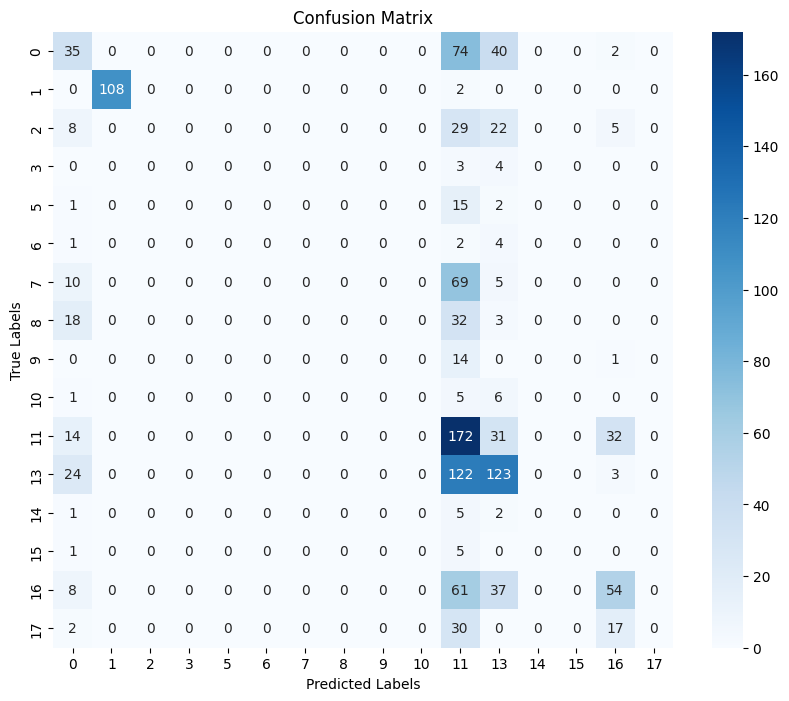

In [26]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, flat_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_upos, yticklabels=unique_upos)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
def calculate_uas(true_heads, pred_heads):
    correct = sum(1 for true, pred in zip(true_heads, pred_heads) if true == pred)
    total = len(true_heads)
    return correct / total

# Extract true and predicted heads
true_heads = [head for example in ud_amharic["test"]["head"] for head in example]
pred_heads = [head for example in predicted_labels for head in example]

# Calculate UAS
uas = calculate_uas(true_heads, pred_heads)
print(f"Unlabeled Attachment Score (UAS): {uas:.4f}")

Unlabeled Attachment Score (UAS): 0.0000


In [28]:
def calculate_las(true_heads, pred_heads, true_labels, pred_labels):
    correct = sum(1 for true_h, pred_h, true_l, pred_l in zip(true_heads, pred_heads, true_labels, pred_labels)
               if true_h == pred_h and true_l == pred_l)
    total = len(true_heads)
    return correct / total

# Calculate LAS
las = calculate_las(true_heads, pred_heads, true_labels, flat_predictions)
print(f"Labeled Attachment Score (LAS): {las:.4f}")

Labeled Attachment Score (LAS): 0.0000
